In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [3]:
pd.set_option('display.max_columns', None)
sns.set_style('dark')

plt.rcParams['figure.figsize'] = [10, 6]

In [4]:
df = pd.read_csv('./data/cleaned_airline.csv')

In [5]:
df.head()

,id,gender,customer_type,age,type_of_travel,flight_distance,inflight_wifi_service,departure_arrival_time_convenient,ease_of_online_booking,gate_location,food_and_drink,online_boarding,seat_comfort,inflight_entertainment,on_board_service,leg_room_service,baggage_handling,checkin_service,inflight_service,cleanliness,departure_delay_in_minutes,arrival_delay_in_minutes,satisfaction,arrival_delayed_missing,satisfaction_codes,age_group_codes,departure_delay_group_codes,arrival_delay_group_codes,class_codes
0,70172,Male,Loyal Customer,13,Personal Travel,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied,0,0,1,2,2,2
1,5047,Male,disloyal Customer,25,Business travel,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied,0,0,3,0,1,0
2,110028,Female,Loyal Customer,26,Business travel,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,satisfied,0,1,3,0,0,0
3,24026,Female,Loyal Customer,25,Business travel,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied,0,0,3,1,1,0
4,119299,Male,Loyal Customer,61,Business travel,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.0,satisfied,0,1,3,0,0,0


In [6]:
df = df.drop(columns=['id'])

## Feature Selection and Splittig

In [7]:
X = df.drop(columns=['satisfaction', 'satisfaction_codes'])
y = df['satisfaction']

In [8]:
df.columns

Index(['gender', 'customer_type', 'age', 'type_of_travel', 'flight_distance',
       'inflight_wifi_service', 'departure_arrival_time_convenient',
       'ease_of_online_booking', 'gate_location', 'food_and_drink',
       'online_boarding', 'seat_comfort', 'inflight_entertainment',
       'on_board_service', 'leg_room_service', 'baggage_handling',
       'checkin_service', 'inflight_service', 'cleanliness',
       'departure_delay_in_minutes', 'arrival_delay_in_minutes',
       'satisfaction', 'arrival_delayed_missing', 'satisfaction_codes',
       'age_group_codes', 'departure_delay_group_codes',
       'arrival_delay_group_codes', 'class_codes'],
      dtype='object')

In [9]:
# cat_cols = X.select_dtypes('object').columns.tolist()
# num_cols = X.select_dtypes('number').columns.tolist()

num_cols = ['age',
 'flight_distance',
 'departure_delay_in_minutes',
 'arrival_delay_in_minutes']

cat_cols = ['gender', 'customer_type', 'type_of_travel']

In [10]:
num_cols

['age',
 'flight_distance',
 'departure_delay_in_minutes',
 'arrival_delay_in_minutes']

In [11]:
cat_cols

['gender', 'customer_type', 'type_of_travel']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [13]:
y_test_int = y_test.map({'neutral or dissatisfied': 0, 'satisfied': 1}) # for roc curve

In [14]:
preprocessor = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), num_cols),
        ('one', OneHotEncoder(), cat_cols)
    ], remainder='passthrough'
)

## Modeling

### Logistic Regression

In [15]:
pipeline_logreg = Pipeline(
    steps=[
        ('preprocess', preprocessor),
        ('model', LogisticRegression())
    ]
)

In [16]:
pipeline_logreg.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('scale', ...), ('one', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transfor

In [17]:
pipeline_logreg.score(X_test, y_test)

0.876106762479148

In [18]:
logred_preds = pipeline_logreg.predict(X_test)

In [19]:
print(classification_report(y_test, logred_preds))

                         precision    recall  f1-score   support

neutral or dissatisfied       0.88      0.91      0.89     17555
              satisfied       0.87      0.84      0.86     13617

               accuracy                           0.88     31172
              macro avg       0.88      0.87      0.87     31172
           weighted avg       0.88      0.88      0.88     31172



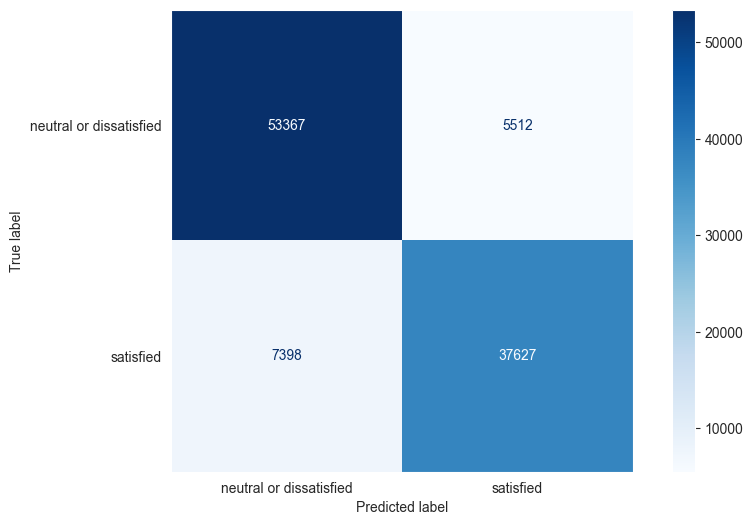

In [20]:

ConfusionMatrixDisplay.from_estimator(pipeline_logreg, X, y, cmap='Blues')
plt.savefig('./images/logreg_conf.png')

In [47]:
logreg_probs = pipeline_logreg.predict_proba(X_test)[:, 1]


roc_auc = roc_auc_score(y_test, logreg_probs)
roc_auc

0.9269122210502743

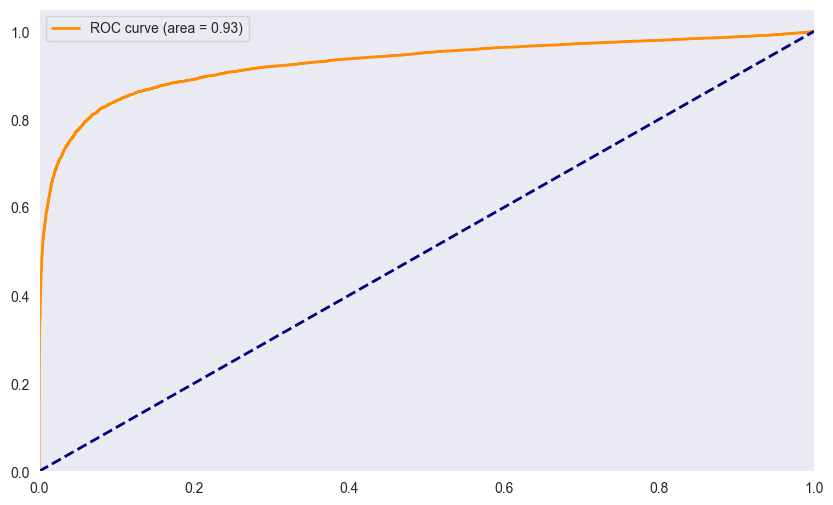

In [48]:
fpr, tpr, thresh = roc_curve(y_test_int, logreg_probs)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend()
plt.savefig('./images/logreg_roc.png')

### Random Forest

In [23]:
pipeline_rf = Pipeline(
    steps=[
        ('preprocess', preprocessor),
        ('model', RandomForestClassifier(random_state=42))
    ]
)

In [24]:
pipeline_rf.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('scale', ...), ('one', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transfor

In [25]:
pipeline_rf.score(X_test, y_test)

0.9626587963557038

In [26]:
rf_preds = pipeline_rf.predict(X_test)

In [27]:
print(classification_report(y_test, rf_preds))

                         precision    recall  f1-score   support

neutral or dissatisfied       0.96      0.98      0.97     17555
              satisfied       0.97      0.94      0.96     13617

               accuracy                           0.96     31172
              macro avg       0.96      0.96      0.96     31172
           weighted avg       0.96      0.96      0.96     31172



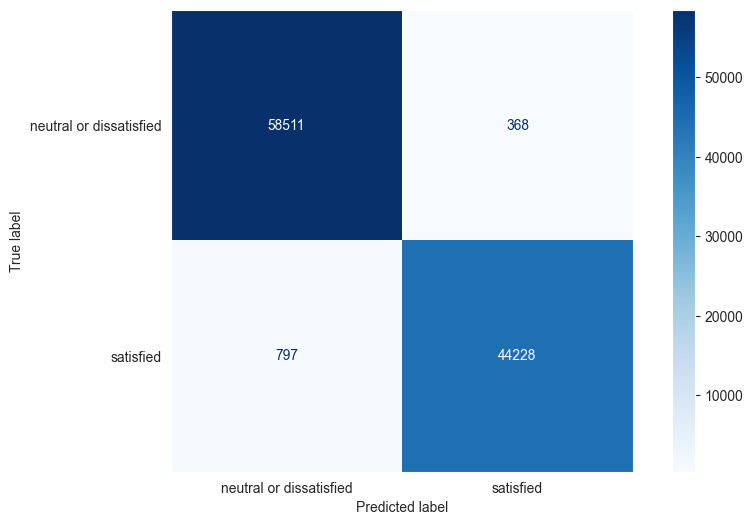

In [28]:
ConfusionMatrixDisplay.from_estimator(pipeline_rf, X, y, cmap='Blues')
plt.savefig('./images/rf_conf.png')

In [51]:
rf_probs = pipeline_rf.predict_proba(X_test)[:, 1]


roc_auc = roc_auc_score(y_test, rf_probs)
roc_auc

0.9937748245440263

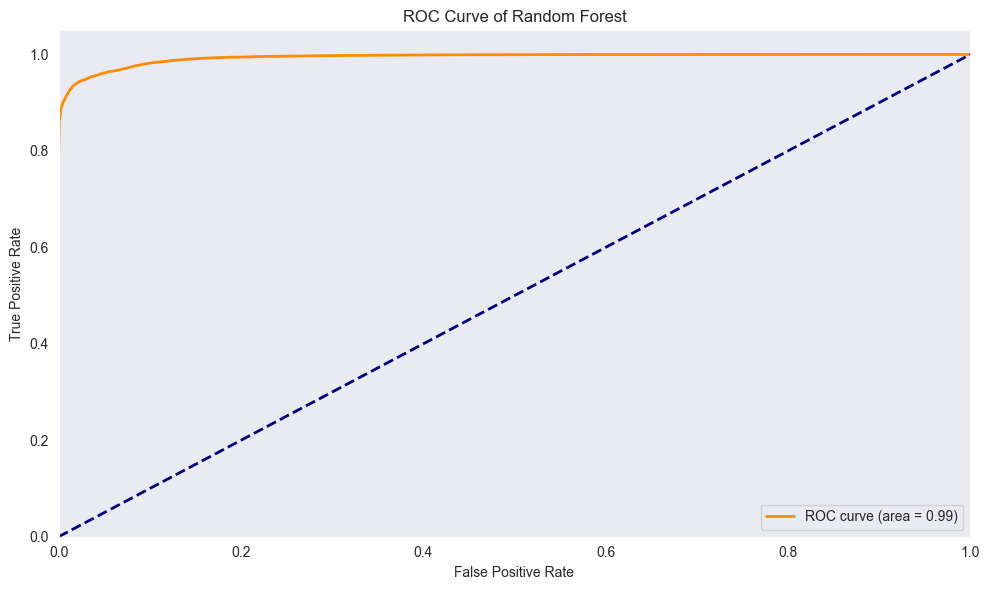

In [54]:
fpr, tpr, thresh = roc_curve(y_test_int, rf_probs)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title("ROC Curve of Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.savefig('./images/rf_roc.png')

> This plot shows the ROC Curve of the Random Forest model. The score it acheives is 0.99, which means that 99% of the time, it will rank a random positive higher than a random negative. There is  threshold where the True Positive Rate is very high, while the False Positive Rate is very low.
>
> In simpler terms, this model has a very good separation between positives and negatives, so it can accurately tell the difference between a positive and a negative. 

### K Nearest Neighbors

In [31]:
pipeline_knn = Pipeline(
    steps=[
        ('preprocess', preprocessor),
        ('model', KNeighborsClassifier())
    ]
)

In [32]:
param_grid = {
    'model__n_neighbors': np.arange(3, 31, 2),
    'model__weights': ['uniform', 'distance']
}

In [33]:
grid_pipe = GridSearchCV(pipeline_knn, param_grid, cv=5)

In [34]:
grid_pipe.fit(X_train, y_train)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...lassifier())])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'model__n_neighbors': array([ 3, 5..., 25, 27, 29]), 'model__weights': ['uniform', 'distance']}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;-

In [35]:
grid_pipe.score(X_test, y_test)

0.9259271140767356

In [36]:
grid_pipe.best_params_

{'model__n_neighbors': np.int64(5), 'model__weights': 'distance'}

In [37]:
knn_preds = grid_pipe.predict(X_test)

In [38]:
print(classification_report(y_test, knn_preds))

                         precision    recall  f1-score   support

neutral or dissatisfied       0.92      0.96      0.94     17555
              satisfied       0.94      0.89      0.91     13617

               accuracy                           0.93     31172
              macro avg       0.93      0.92      0.92     31172
           weighted avg       0.93      0.93      0.93     31172



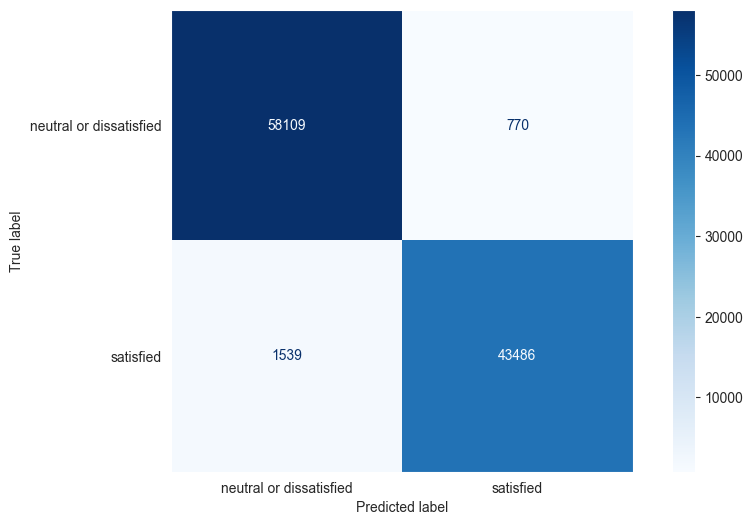

In [39]:
ConfusionMatrixDisplay.from_estimator(grid_pipe.best_estimator_, X, y, cmap='Blues')
plt.savefig('./images/knn_conf.png')

In [49]:
knn_probs = grid_pipe.predict_proba(X_test)[:, 1]


roc_auc = roc_auc_score(y_test, knn_probs)
roc_auc

0.9701724185930655

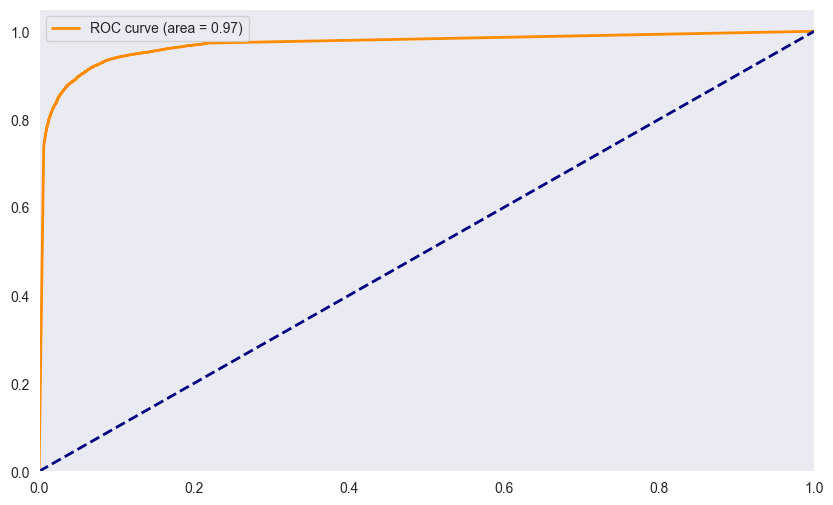

In [50]:
fpr, tpr, thresh = roc_curve(y_test_int, knn_probs)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend()
plt.savefig('./images/knn_roc.png')

## Saving Models

In [42]:
import joblib

In [43]:
joblib.dump(pipeline_logreg, './models/logreg.pkl')

['./models/logreg.pkl']

In [44]:
joblib.dump(pipeline_rf, './models/rf.pkl')

['./models/rf.pkl']

In [45]:
joblib.dump(grid_pipe, './models/knn.pkl')

['./models/knn.pkl']